# Model Comparison

In this notebook, I will show about how different models, `caffenet`, `vgg_cnn_m_1024` and `vgg16`, affect the performance. This three models use the same dataset (PASCAL VOC) for training, but vary in network structure: `caffenet` (model **S**) is the smallest one, `vgg_cnn_m_1024` (model **M**) is wider, and `vgg16` (model **L**) is both wider and deeper. 

These 3 models are official pretrained datasets in the fast rcnn paper.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import _init_paths
import skimage.data
import matplotlib.pyplot as plt

from process_platform.image_reader import ImageReader
from process_platform.regionizer   import Regionizer
from process_platform.detector     import Detector
from process_platform.labelizer    import Labelizer
from process_platform.visualizer   import Visualizer

## Build the platform

Initialize modules with different configurations.

In [2]:
image_reader = ImageReader()
recognizer = Regionizer(min_patch=2000) # to select **almost** only the largest plane region
labelizer = Labelizer()
visualizer = Visualizer()

## Read Image

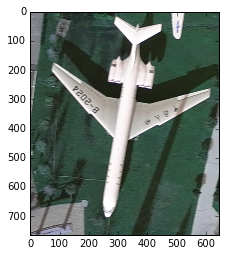

In [3]:
from fast_rcnn.config import cfg

img_path = os.path.join(cfg.ROOT_DIR, 'data', 'uav', 'super_small_example.jpg')
img = image_reader.read(img_path)
plt.imshow(img)

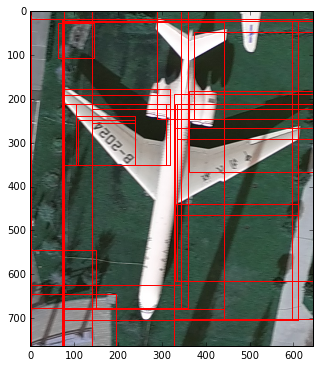

In [4]:
candidates = recognizer.show_regions(img)

## Detect and Labelize

Use three different detectors. In order to compare these three models, the `max_score` for `aeroplane` class will be used. `max_score` refers to the score of the region which has the highest score in class `aeroplane`.

using detector 2_l_model ...
Max score for class aeroplane: 0.594095
Region index with max score 8
6.25440768898 0.0 644.0 743.38984183


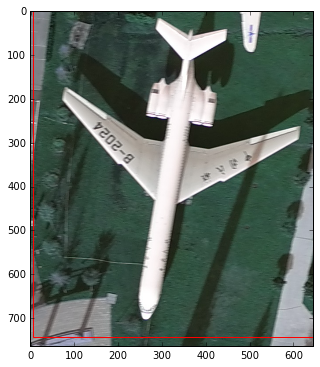

using detector 1_m_model ...
Max score for class aeroplane: 0.285167
Region index with max score 15
54.0376216313 0.0 549.682148113 744.616854645


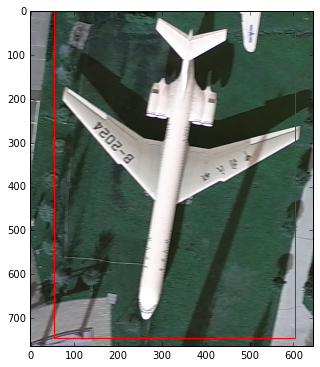

using detector 0_s_model ...
Max score for class aeroplane: 0.206431
Region index with max score 21
0.0749689931981 0.347069901647 644.0 763.0


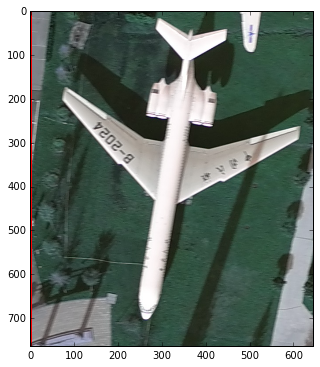

In [10]:
detectors = {
    '0_s_model': 'caffenet',
    '1_m_model': 'vgg_cnn_m_1024',
    '2_l_model': 'vgg16' 
}
import numpy as np
import matplotlib.patches as patches

max_scores = {}
for name, net_name in detectors.items():
    print 'using detector %s ...' % name
    if name == '2_l_model':
        # will fail due to large memory usage on GPU, so choose CPU instead
        detector = Detector(net_name=net_name, mode='cpu')
    else:
        detector = Detector(net_name=net_name)
        
    scores, boxes = detector.detect(img, candidates)
    # class index for aeroplane is 1
    cls = 'aeroplane'
    cls_ind = 1
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_scores = scores[:, cls_ind]
    print 'Max score for class %s: %lf' % (cls, np.max(cls_scores))
    print 'Region index with max score', np.argmax(cls_scores)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img)
    x, y, h, w = cls_boxes[np.argmax(cls_scores)]
    print x, y, h, w
    ax.add_patch(patches.Rectangle((x,y), h, w, fill=False, edgecolor='red'))
    plt.show()
    
    max_scores[name] = np.max(cls_scores)

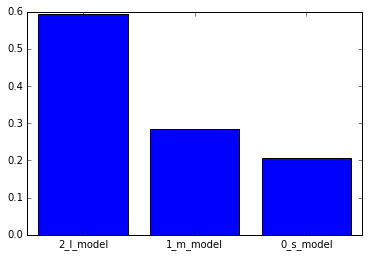

In [6]:
plt.bar(range(len(max_scores)), max_scores.values(), align='center')
plt.xticks(range(len(max_scores)), max_scores.keys())
plt.show()

## Conclusion

According to the figure above, larger model do have larger score on the aeroplane class. However, none of these models can reach the score min threshold `0.8`. This might indicates that network architecture is not the main reason for miss detection.

Take a look at the dataset used in training: http://host.robots.ox.ac.uk/pascal/VOC/thumbs/Caltech/airplanes_side/index1.html. Nearly all the aeroplane pictures are taken from side, which means the features from above might not be discovered after training.

In order to solve this dataset problem, there's another dataset only for aircrafts: http://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/. 